# Imports 

In [2]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import math
import cmath
from tqdm import tqdm
import glob
import scipy
from scipy import io as sio

# Input parameters 

In [6]:
## Inputs

raw_data_path = "../../../Dataset/image_domain/Augmented_dataset/64_64_2*"
ph_size = 64
grid_size = 500
r = 200
n_transducers = 64

c = 1500

wn = 64
f_start = 100000
f_end = 5000000

# Weight Matrix Generation for 'N' Frequenices 

### Function to calculate weights after distances are calculated 

In [3]:
def Calculate_W_matrix(w):
    W_matrix = distance
    final = np.zeros(W_matrix.shape[0]).astype(complex)
    
    for i in range(W_matrix.shape[0]):
        d = W_matrix[i]
        x = (w/c)*d
        z = complex(0, x)
        temp = (w * cmath.exp(z)) / d
        
        j = complex(0,-1)
        temp = temp * j
        
        final[i] = temp
    final = np.reshape(final, (n_transducers, ph_size*ph_size))
    return final

### Calculate distances between transducers and ROI 

In [4]:
ph = np.empty((ph_size, ph_size))


#     Create a grid

grid = np.zeros((grid_size, grid_size))
left = (grid_size - ph_size) // 2
right = (grid_size + ph_size) // 2
top = (grid_size - ph_size) // 2
bottom = (grid_size + ph_size) // 2
grid[left:right,top:bottom] = ph
theta = np.linspace(0, 2*np.pi, n_transducers, endpoint=False)
offset = grid_size // 2
x = r*np.cos(theta) + offset
y = r*np.sin(theta) + offset

x = x[::-1]; x = np.append(x[-1], x[:-1])
y = y[::-1]; y = np.append(y[-1], y[:-1])

td_loc = tuple(zip(x,y))

#     Get list of points of phantom

#     Get ROI
roi = []
for i in range(top, bottom):
    for j in range(left, right):
        roi.append((j,i))

#     Calculate distances from Each Transducer to each pixel in ROI
distance = []
for i in range(len(td_loc)):
    for j in range(len(roi)):
        d = math.dist(td_loc[i], roi[j]) * 0.0001
        distance.append(d)
        
distance = np.asarray(distance)

### Compute Weight matrix using the defined function

In [5]:
w_range = list(np.linspace(f_start, f_end, wn))
weight_matrix = []
for i in tqdm(w_range):
    weight_matrix.append(Calculate_W_matrix(i))
    
weight_matrix = np.asarray(weight_matrix)    

100%|███████████████████████████████████████████| 64/64 [00:40<00:00,  1.58it/s]


### Save Weight Matrix as npy file

In [5]:
np.save("weights/weight_matrix_{}_{}_{}".format(ph_size, n_transducers, wn), weight_matrix)

NameError: name 'weight_matrix' is not defined

# Calculate P = WX matrix for all Images

### Load Weight Matrix 

In [7]:
weight_matrix = np.load("weights/weight_matrix_{}_{}_{}.npy".format(ph_size, n_transducers, wn))

FileNotFoundError: [Errno 2] No such file or directory: 'weights/weight_matrix_64_64_64.npy'

In [6]:
def normalize_sensor_data(sensor):
    sensor = sensor.flatten()
    abs_sens = abs(sensor)
    phase = np.asarray([cmath.phase(i) for i in sensor])
    norm_abs = (abs_sens - min(abs_sens)) / (max(abs_sens) - min(abs_sens))
    norm_phase = (phase - min(phase)) / (max(phase) - min(phase)) 
    norm_P = [cmath.rect(norm_abs[i], norm_phase[i]) for i in range(len(norm_abs))]
    norm_P = np.reshape(np.asarray(norm_P), (ph_size, ph_size))
    return norm_P

In [20]:
count = 0
for filename in tqdm(glob.glob(raw_data_path)):
    count += 1
#     Get X
    ph = Image.open(filename)
    ph = ph.resize([ph_size, ph_size], Image.ANTIALIAS)
#     mat = sio.loadmat(filename)
#     ph = mat['X'].copy()
#     ph = Image.fromarray(np.uint8(ph)*255)
#     ph = ph.resize([ph_size, ph_size], Image.ANTIALIAS)
    ph = np.asarray(ph)
    X = ph.flatten()
    
#     Calculate P = WX
    P = []
    for i in range(len(weight_matrix)):
        P.append(np.matmul(weight_matrix[i], X))
    P = np.asarray(P)
#     pol = np.dstack((np.abs(P), np.angle(P)))
    P_abs = abs(P)
    
    max_truth = max(ph.flatten())
    min_truth = min(ph.flatten())
    
    max_sensor = max(P.flatten())
    min_sensor = min(P.flatten())
    
    sensor_norm = normalize_sensor_data(P)
    
    phase = [cmath.phase(i) for  i in P.flatten()]
    
    max_phase = max(phase)
    min_phase = min(phase)
    
    sio.savemat("../../../Dataset/sensor_domain/simple_128_128_split/binary_{}.mat".format(count),
                dict(sensor=P, truth=ph, sensor_norm=sensor_norm, P_abs=P_abs,
                     max_truth=max_truth, min_truth=min_truth,
                     max_sensor=max_sensor, min_sensor=min_sensor,
                     max_phase=max_phase, min_phase=min_phase))
    

100%|███████████████████████████████████████| 1993/1993 [06:53<00:00,  4.82it/s]


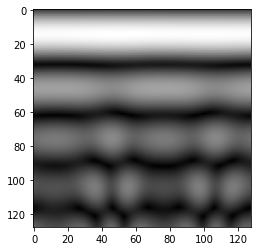

In [21]:
mat = sio.loadmat("../../../Dataset/sensor_domain/simple_128_128/binary_3.mat")
x = mat["sensor"]
plt.imshow(abs(x), cmap="gray")

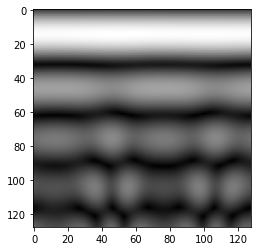

In [22]:
x = mat["sensor_norm"]
plt.imshow(abs(x), cmap="gray")

In [23]:
x = mat["P_abs"]
plt.imshow(abs(x), cmap="gray")

KeyError: 'P_abs'

In [ ]:
img = mat["truth"]
plt.imshow(img, cmap="gray")